In [70]:
from lib.utils import *
from lib.E15Analyzer import E15Analyzer
from lib.plot_utils import *
from lib.MyGeneAnalyzer import MyGeneAnalyzer
from lib.plot_utils import *
from lib.utils import *

In [2]:
%load_ext autoreload
%autoreload 2

### The goal of this notebook is to highlight that the number of counts > 100 do not affect overall enrichments and results from GO analyses.

In [3]:
counts = pd.read_csv('../data/20180516_rna_tophat/time_all/counts.gz', index_col=0)
genes_100 = counts[counts.sum(axis=1) >= 100].index

In [4]:
genes_100

Index(['ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000031', 'ENSMUSG00000000037', 'ENSMUSG00000000056', 'ENSMUSG00000000058', 'ENSMUSG00000000078', 'ENSMUSG00000000085', 'ENSMUSG00000000088', 'ENSMUSG00000000093',
       ...
       'ENSMUSG00000098933', 'ENSMUSG00000098967', 'ENSMUSG00000098979', 'ENSMUSG00000099034', 'ENSMUSG00000099083', 'ENSMUSG00000099094', 'ENSMUSG00000099137', 'ENSMUSG00000099267', 'ENSMUSG00000099297', 'ENSMUSG00000099320'], dtype='object', length=16440)

In [5]:
counts[counts.index.isin(genes_100)].sum(axis=1).sort_values(ascending=False)

ENSMUSG00000064351    3069438
ENSMUSG00000064358    1765300
ENSMUSG00000064370    1547457
ENSMUSG00000037742    1446696
ENSMUSG00000064357    1390133
                       ...   
ENSMUSG00000086150        100
ENSMUSG00000031253        100
ENSMUSG00000091947        100
ENSMUSG00000037627        100
ENSMUSG00000097016        100
Length: 16440, dtype: int64

In [7]:

# clusters[clusters['ensembl_gene_id'].isin(genes_100)]

In [52]:
clusters = DataFrameAnalyzer.read_tsv_gz(clusters_path)
clusters['sum.counts'] = clusters.ensembl_gene_id.map(counts.sum(axis=1).to_dict())
clusters['min.counts'] = clusters.ensembl_gene_id.map(counts.max(axis=1).to_dict())
genes_100 = clusters[clusters['min.counts'] > 100].sort_values('min.counts').ensembl_gene_id

expr = E15Analyzer.get_expr_values(tophat=True, basedir='../data/20180516_rna_tophat')
expr = expr.sort_values('padj')
expr =  expr.sort_values('padj').drop_duplicates('ensembl_gene_id').set_index('ensembl_gene_id')['padj'].to_dict()
print(len(expr))
genes_padj_001 = {k for k in expr if expr[k] < 0.01}
print(len(genes_padj_001))

24768
8692


In [56]:

# jobid = 1
# for nki in range(1, 21):
remove_forskolin = True
n_genes = 5000 #  # 2000 # 5000
padj_thr = 0.01 # None # 0.05 # 1e-15  # 0.0001

for nki in range(10, 11):

    # if nki != jobid:
    #     continue
        
    for filter_100_counts in [True, False]:
        print('\n\n\nNEXT QUERY')
        output_path_go = join("../data/" + str(nki) + ("_no_forskolin" if remove_forskolin else '') +"_go.pkl")
        if filter_100_counts:
            output_path_go = output_path_go.replace('.pkl', '_filter100counts.pkl')
        if padj_thr is not None:
            output_path_go = output_path_go.replace('.pkl', '_padj_%.3g.pkl' % padj_thr)
            
        print(exists(output_path_go), output_path_go)
        if exists(output_path_go):
            continue
            
        expr = E15Analyzer.get_expr_values(tophat=True, basedir='../data/20180516_rna_tophat')
        expr['count.100.or.more'] = expr['ensembl_gene_id'].isin(genes_100)
        
        
        print(expr.shape)
        print(expr['count.100.or.more'].value_counts())
        
#         if filter_100_counts:
#             expr = expr[expr['count.100.or.more'] == True]
        
        if remove_forskolin:
            expr = expr[expr['stimuli'] != 'forskolin']

        print(expr.shape)

        ensembl_gene_ids = set()
        if n_genes != None:
            expr = expr.sort_values('padj')
            ensembl_gene_ids = set()
            for ri, r in expr.iterrows():
                ensembl_gene_ids.add(r['ensembl_gene_id'])
                if len(ensembl_gene_ids) == n_genes:
                    break
        else:
            ensembl_gene_ids = set(expr[expr['padj'] < padj_thr]['ensembl_gene_id'])
            n_genes = len(ensembl_gene_ids)

        expr = expr[expr['ensembl_gene_id'].isin(ensembl_gene_ids)]
        expr = expr.pivot('ensembl_gene_id', 'treatment', 'log2FoldChange')
        new_cols = [treatment + "_" + time for treatment in ['bdnf', 'KCl', 'forskolin'] for time in ['1h', '6h', '10h']]
        expr = expr[[c for c in new_cols if c in expr]]

        expr_rowZscores = expr.sub(expr.mean(axis=1), axis=0).divide(expr.std(axis=1), axis=0)

        clusters_path = join("../data/" + str(nki) + ("_no_forskolin" if remove_forskolin else '') + ".tsv.gz")
        if not exists(clusters_path):
            print('cannot run. Path for clusters does not exist')
            print(clusters_path)
            continue

        clusters = DataFrameAnalyzer.read_tsv_gz(clusters_path)
        clusters['ensembl_gene_id'] = expr_rowZscores.index
        
        if filter_100_counts:
            clusters = clusters[clusters['ensembl_gene_id'].isin(genes_100)]
        if padj_thr is not None:
            clusters = clusters[clusters['ensembl_gene_id'].isin(genes_padj_001)]
             
        symbol_by_ensembl = MyGeneAnalyzer.get_symbol_by_ensembl(clusters['ensembl_gene_id'], species='mouse')

        from lib.GOAnalyzer import GOAnalyzer
        res_by_nk = {}

        print(clusters.head())
        print(clusters.shape)
        
        # assert False
        # cluster_profiler
        output_topGO = join("../data/" + str(nki) + ("_no_forskolin" if remove_forskolin else '') + "_topGO_go.pkl")
        if filter_100_counts:
            output_topGO = output_topGO.replace('.pkl', '_filter100counts.pkl')
        if padj_thr is not None:
            output_topGO = output_topGO.replace('.pkl', '_padj_%.3g.pkl' % padj_thr)
            

        print(exists(output_topGO), output_topGO)
        
        if not exists(output_topGO):
            for next_nki, grp in clusters.groupby('n.' + str(nki)):

                print('shape of clusters dataframe', clusters.shape)
                
                fg_ensembl = set(grp['ensembl_gene_id'])
                bg_ensembl = set(clusters['ensembl_gene_id']) - fg_ensembl
                print('next cluster group', next_nki)
                # print(len(fg_ensembl), len(bg_ensembl))
                # print(list(fg_ensembl)[:3])
                # print(list(bg_ensembl)[:3])

                fg_symbol = set(grp['ensembl_gene_id'].map(symbol_by_ensembl))
                bg_symbol = set(clusters['ensembl_gene_id'].map(symbol_by_ensembl)) - fg_symbol
                # print(list(fg_symbol)[:3])
                # print(list(bg_symbol)[:3])
                # print(len(fg_symbol), len(bg_symbol))
                k = str(nki) + "_" + str(next_nki)
                output_topGO_table = output_topGO.replace(".pkl", '_' + str(next_nki) + '.tsv.gz')
                bash_topGO = output_topGO_table.replace(".tsv.gz", '.sh')
                topGO = None
                if not exists(output_topGO_table):
                    _, topGO, _, _ = GOAnalyzer.run_go_three_way(fg_ensembl, bg_ensembl,
                                                                                   fg_symbol, bg_symbol, 'mouse',
                                                                                   run_clusterProfiler=False,
                                                                                   run_topGO=True,
                                                                                   run_stringDB=False,
                                                                                    output_clusterProf=output_topGO_table,
                                                              bash_path_clusterProf=bash_topGO, skip=True)
                    DataFrameAnalyzer.to_tsv_gz(topGO, output_topGO_table)
                else:
                    topGO = DataFrameAnalyzer.read_tsv_gz(output_topGO_table)

                res_by_nk[k] = [topGO]
            DataFrameAnalyzer.to_pickle(res_by_nk, output_topGO)

        print(output_topGO)
        res_by_nk = DataFrameAnalyzer.read_pickle(output_topGO)

        for next_nki, grp in clusters.groupby('n.' + str(nki)):
            if len(res_by_nk.keys()) > 0:
                 break

            print('shape of clusters dataframe', clusters.shape)
            
            fg_ensembl = set(grp['ensembl_gene_id'])
            bg_ensembl = set(clusters['ensembl_gene_id']) - fg_ensembl
            # print(len(fg_ensembl), len(bg_ensembl))
            # print(list(fg_ensembl)[:3])
            # print(list(bg_ensembl)[:3])
            fg_symbol = set(grp['ensembl_gene_id'].map(symbol_by_ensembl))
            bg_symbol = set(clusters['ensembl_gene_id'].map(symbol_by_ensembl)) - fg_symbol
            # print(list(fg_symbol)[:3])
            # print(list(bg_symbol)[:3])

            k = str(nki) + "_" + str(next_nki)
            clusterProf = res_by_nk[k][0] if k in res_by_nk else None
            clusterProf, topGO, stringDB, hm = GOAnalyzer.run_go_three_way(fg_ensembl, bg_ensembl,
                                                                       fg_symbol, bg_symbol, 'mouse',
                                                                       run_clusterProfiler=False,
                                                                       run_topGO=True,
                                                                       run_stringDB=False,
                                                                       df_clusterProfiler=clusterProf)
            res_by_nk[k] += [clusterProf, topGO, stringDB, hm]

        DataFrameAnalyzer.to_pickle(res_by_nk, output_path_go)
        # assert False





NEXT QUERY
False ../data/10_no_forskolin_go_filter100counts_padj_0.01.pkl
(207285, 12)
False    163122
True      44163
Name: count.100.or.more, dtype: int64
(138190, 12)
querying genes...
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4907...done.
Finished.
32 input query terms found no hit:
	['ENSMUSG00000021745', 'ENSMUSG00000023846', 'ENSMUSG00000029333', 'ENSMUSG00000034007', 'ENSMUSG000
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
removing repeated genes...
   id  n.2  n.3  n.4  n.5  n.6  n.7  n.8  n.9  n.10     ensembl_gene_id
0   1    1    1    1    1    1    1    1    1     1  ENSMUSG00000000001
1   2    1    1    2    2    2    2    2    2     2  ENSMUSG00000000031
2   3    2    2    3    3    3    3    3    3     3  ENSMUSG00000000056
3   4    2    2    3    3    3    3    3    3     4  ENSMUSG00000000058
4   5    2    2    1    1    3    1    4    4     1  ENSMUS

AssertionError: 

In [57]:
!ls -ltrh ../data/10_no_forskolin_go*.pkl

-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 11M Feb 20 18:59 ../data/10_no_forskolin_go.pkl
-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 13M Feb 20 19:08 ../data/10_no_forskolin_go_filter100counts.pkl
-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 13M Jun 18 17:50 ../data/10_no_forskolin_go_padj_0.01.pkl
-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 13M Jun 18 18:27 ../data/10_no_forskolin_go_filter100counts_padj_0.01.pkl


In [135]:
import pickle

In [140]:
res_by_nk = pickle.load(open('../data/10_no_forskolin_go.pkl', 'rb'))
res_by_nk_100counts = pickle.load(open('../data/10_no_forskolin_go_filter100counts_padj_0.01.pkl', 'rb'))

In [137]:
import scipy

In [138]:
%matplotlib inline

10_1 (6560, 16) (6976, 17)
10_2 (6560, 16) (6976, 17)
10_3 (6560, 16) (6976, 17)
10_4 (6560, 16) (6976, 17)
10_5 (6560, 16) (6976, 17)
10_6 (6560, 16) (6976, 17)
10_7 (6560, 16) (6976, 17)
10_8 (6560, 16) (6976, 17)
10_9 (6560, 16) (6976, 17)
10_10 (6978, 16) (6976, 17)


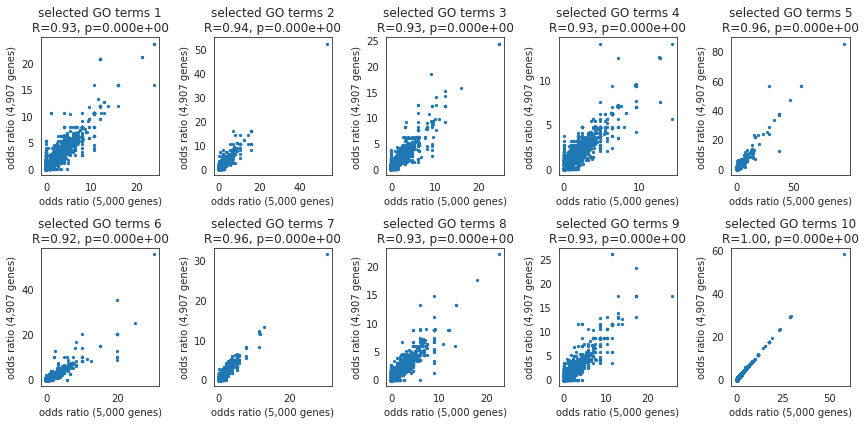

In [230]:
rcParams['figure.figsize'] = 12, 6
pi = 0
topGO_100counts = []
for k in res_by_nk.keys():
    plt.subplot(2, 5, pi + 1)
    df1 = res_by_nk[k][0]
    df2 = res_by_nk_100counts[k][0]
    print(k, df1.shape, df2.shape)
    
    df3 = df1.merge(df2, on='GO.ID')
    x, y = df3['odd.ratio_x'].values, df3['odd.ratio_y'].values
    nas = np.logical_or(np.isnan(x), np.isnan(y))
    inf = np.logical_or(np.isinf(x), np.isinf(y))
    # x = x[~np.isnan(x)], x[~np.isnan(x)]
    r, pval = scipy.stats.pearsonr(x[~nas & ~inf], y[~nas & ~inf])

    plt.scatter(df3['odd.ratio_x'], df3['odd.ratio_y'], s=5)
    
    plt.xlabel('odds ratio (5,000 genes)')
    plt.ylabel('odds ratio (4,907 genes)')
    plt.title('selected GO terms %s\nR=%.2f, p=%.3e' % (k.split('_')[1], r, pval))
    
    pi += 1
    df2['nk'] = int(k.split('_')[1])
    topGO_100counts.append(df2)
plt.tight_layout()
plt.show()

topGO_100counts = pd.concat(topGO_100counts).reset_index(drop=True)

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Compare versus the original GOs file

In [73]:
!ls -ltrh 10*

-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 1.7M Jun 25 10:27 10_go.tsv.gz
-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 162K Jun 25 10:44 10_no_forskolin_topGO_go_10.tsv.gz
-rw-r--r--. 1 ignacio.ibarra OG-ICB-User 7.2M Jun 25 10:54 10_go_no_forskolin.xlsx


In [194]:
go_ori = pd.read_excel('10_go_no_forskolin.xlsx', index_col=0)

# top terms selected for visualization
go_ori_top = pd.read_excel('10_go_no_forskolin.xlsx', index_col=0, sheet_name='Sheet3')
go_ori_top = go_ori_top[~pd.isnull(go_ori_top.index)]

In [195]:
go_ori = go_ori[go_ori['GO.ID'].isin(go_ori_top['GO.ID'])]


In [196]:
topGO_sig = go_ori.pivot('nk', 'GO.ID', 'minus.log10.padj').T.reindex(go_ori_top['GO.ID'])
topGO_odd = go_ori.pivot('nk', 'GO.ID', 'odd.ratio').T.reindex(go_ori_top['GO.ID'])

topGO_sig.index = [c + ", " + name_by_topGO[c] for c in topGO_sig.index]
topGO_odd.index = [c + ", " + name_by_topGO[c] for c in topGO_odd.index]

topGO_sig = topGO_sig[~topGO_sig.index.duplicated(keep='first')]
topGO_odd = topGO_odd[~topGO_odd.index.duplicated(keep='first')]


before plotting dimensions...
(40, 10)
('legends', [1, 2, 3, 4])
1.0
('next size', 9.0)
1.0
('next size', 18.0)
1.0
('next size', 27.0)
1.0
('next size', 36.0)


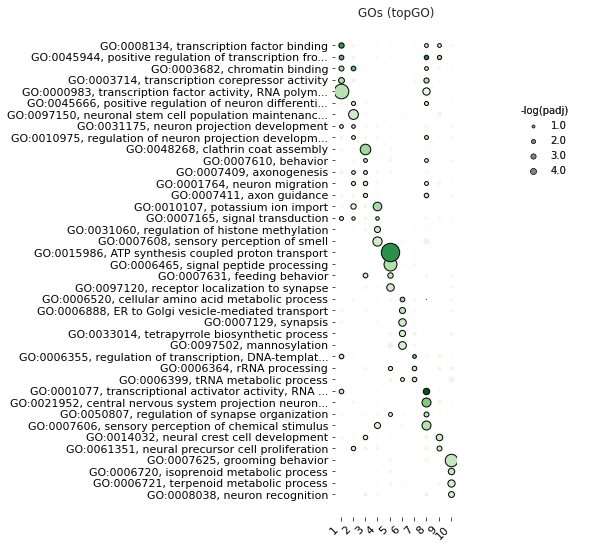

In [197]:
rcParams['figure.figsize'] = 10, 20

heatmap_grid = [2   , 4, 1, 2, 1, 1] # grid spec, rowi, coli, rowspan, colspan
colorbar_grid = [4, 4, 3, 3, 1, 1] # grid spec, rowi, coli, rowspan, colspan
circle_legend_bbox = [2.0, 0.85]
line_widths = pd.DataFrame(np.where(topGO_sig > -np.log10(0.1), 1.0, 0), index=topGO_sig.index,
                           columns=topGO_sig.columns)
CirclesHeatmap.make_bubble_heatmap(topGO_sig, topGO_odd, vmin=0, vmax=9, quantAmplifier=3,
                                   heatmap_grid=heatmap_grid, fig=fig, marker="o",
                                   circle_legend_bbox=circle_legend_bbox, xlab='', rotation_xlabs=45, ha_xlabs='right',
                                   heatmap_title='GOs (topGO)', palette_id='Greens',
                                   line_widths=line_widths,
                                   circle_legend_ticks=[1, 2, 3, 4], ylab='', tickscolorbar=[0, 1, 2],
                                   circles_legend_title='-log(padj)', cbar_label='log2 odds ratio',
                                   colorbar_grid=colorbar_grid, grid=False)
# savepdf('/tmp/dotplot_test' + ("_no_forskolin" if remove_forskolin else ''))
plt.show()
plt.close()


### New values

In [199]:

go_ori = topGO_100counts[topGO_100counts['GO.ID'].isin(go_ori_top['GO.ID'])]
go_ori['minus.log10.padj'] = -np.log10(go_ori['Fisher.elim'].astype(float))

/home/icb/ignacio.ibarra/miniconda3/envs/mypython3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [201]:
print(go_ori.shape)
topGO_sig_new = go_ori.pivot('nk', 'GO.ID', 'minus.log10.padj').T.reindex(go_ori_top['GO.ID'])
topGO_odd_new = go_ori.pivot('nk', 'GO.ID', 'odd.ratio').T.reindex(go_ori_top['GO.ID'])
print(topGO_sig_new.shape)
topGO_sig_new.index = [c + ", " + name_by_topGO[c] for c in topGO_sig_new.index]
topGO_odd_new.index = [c + ", " + name_by_topGO[c] for c in topGO_odd_new.index]

topGO_sig_new = topGO_sig_new[~topGO_sig_new.index.duplicated(keep='first')]
topGO_odd_new = topGO_odd_new[~topGO_odd_new.index.duplicated(keep='first')]
print(topGO_sig_new.shape)


(380, 18)
(42, 10)
(40, 10)


In [202]:
topGO_sig_new = topGO_sig_new[~topGO_sig_new.isnull().any(axis=1)]
topGO_odd_new = topGO_odd_new[~topGO_odd_new.isnull().any(axis=1)]

before plotting dimensions...
(38, 10)
('legends', [1, 2, 3, 4])
1.0
('next size', 16.0)
1.0
('next size', 32.0)
1.0
('next size', 48.0)
1.0
('next size', 64.0)


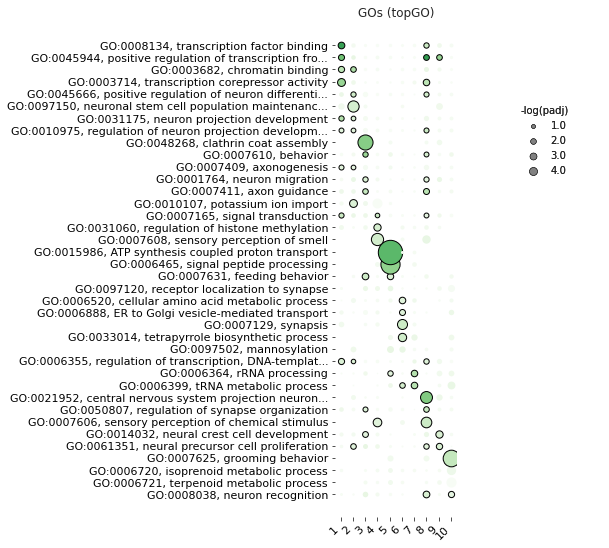

In [233]:
rcParams['figure.figsize'] = 10, 20

heatmap_grid = [2   , 4, 1, 2, 1, 1] # grid spec, rowi, coli, rowspan, colspan
colorbar_grid = [4, 4, 3, 3, 1, 1] # grid spec, rowi, coli, rowspan, colspan
circle_legend_bbox = [2.0, 0.85]
line_widths = pd.DataFrame(np.where(topGO_sig_new > -np.log10(0.1), 1.0, 0), index=topGO_sig_new.index,
                           columns=topGO_sig_new.columns)
CirclesHeatmap.make_bubble_heatmap(topGO_sig_new, topGO_odd_new, vmin=0, vmax=9, quantAmplifier=4,
                                   heatmap_grid=heatmap_grid, fig=fig, marker="o",
                                   circle_legend_bbox=circle_legend_bbox, xlab='', rotation_xlabs=45, ha_xlabs='right',
                                   heatmap_title='GOs (topGO)', palette_id='Greens',
                                   line_widths=line_widths,
                                   circle_legend_ticks=[1, 2, 3, 4], ylab='', tickscolorbar=[0, 1, 2],
                                   circles_legend_title='-log(padj)', cbar_label='odds ratio',
                                   colorbar_grid=colorbar_grid, grid=False)
savepdf('../data/figures/dotplot_test_001.pdf')
plt.show()
plt.close()


Text(0, 0.5, 'log2 odd ratios (4,9071 genes)')

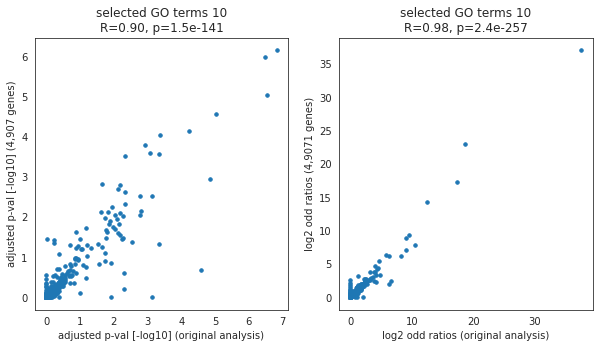

In [227]:
rcParams['figure.figsize'] = 10, 5
x, y = topGO_sig[topGO_sig.index.isin(topGO_sig_new.index)].values.flatten(), topGO_sig_new.values.flatten()

nas = np.logical_or(np.isnan(x), np.isnan(y))
inf = np.logical_or(np.isinf(x), np.isinf(y))
    
r, pval = scipy.stats.pearsonr(x[~nas & ~inf], y[~nas & ~inf])
plt.title('subcluster %s\nR=%.2f' % (k.split('_')[1], r))
    
plt.subplot(1, 2, 1)
plt.scatter(x, y, s=12)
# plt.title('selected GO terms')
plt.title('selected GO terms %s\nR=%.2f, p=%.2g' % (k.split('_')[1], r, pval))
plt.xlabel('adjusted p-val [-log10] (original analysis)')
plt.ylabel('adjusted p-val [-log10] (4,907 genes)')

x, y = topGO_odd[topGO_odd.index.isin(topGO_odd_new.index)].values.flatten(), topGO_odd_new.values.flatten()

nas = np.logical_or(np.isnan(x), np.isnan(y))
inf = np.logical_or(np.isinf(x), np.isinf(y))

r, pval = scipy.stats.pearsonr(x[~nas & ~inf], y[~nas & ~inf])
plt.subplot(1, 2, 2)
plt.scatter(x, y, s=12)
# plt.title('selected GO terms')
plt.title('selected GO terms %s\nR=%.2f, p=%.2g' % (k.split('_')[1], r, pval))
plt.xlabel('log2 odd ratios (original analysis)')
plt.ylabel('log2 odd ratios (4,9071 genes)')
